In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import os
import gzip
import glob
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from time import time

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten,BatchNormalization
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import TensorBoard

In [3]:
tf.__version__

'1.12.0'

In [4]:
num_classes = 96
img_size_flat = 28*28*3
img_shape_full = (28,28,3)
TotalSize = 96000

In [5]:
x = []
y_class = []
p = 0
for i in glob.glob("classes1/*"):
    for j in glob.glob(i+'/*.jpeg'):
        im = cv2.imread(j)
        x.append(im)
        temp = []
        temp.append(os.path.basename(i))
        temp.append(p)
        y_class.append(temp)
    p+=1
x = np.array(x)
y_class = np.array(y_class)

In [6]:
x_train, x_test, y_train_cls, y_test_cls = train_test_split(x, y_class, test_size=0.40, random_state=42)
train_size = y_train_cls.shape[0]
test_size = y_test_cls.shape[0]
print(train_size,test_size)

57600 38400


In [7]:
b = np.zeros((train_size, num_classes))
b[np.arange(train_size), y_train_cls[:,1].astype(int)] = 1
y_train = b

In [8]:
b = np.zeros((test_size, num_classes))
b[np.arange(test_size), y_test_cls[:,1].astype(int)] = 1
y_test = b

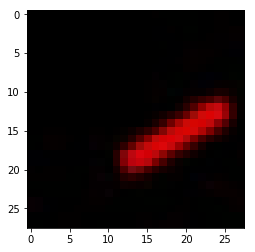

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
imgplot = plt.imshow(x_train[3])
plt.show()
print(y_train[3])

In [10]:
model = Sequential()

model.add(InputLayer(input_shape=(28,28,3,)))

model.add(Conv2D(kernel_size=7, strides=1, filters=32,
                 activation='relu', name='layer_conv1'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 22, 22, 32)        4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3965952   
_________________________________________________________________
dense_1 (Dense)              (None, 96)                98400     
Total params: 4,069,216
Trainable params: 4,069,152
Non-trainable params: 64
_________________________________________________________________

In [12]:
optimizer = Adam(lr=1e-3)

In [13]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [15]:
model.fit(x=x_train,
          y=y_train,
          epochs=3, batch_size=128,verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard])

Train on 57600 samples, validate on 38400 samples
Epoch 1/3
57600/57600 [==============================] - 11s 197us/step - loss: 1.3323 - acc: 0.6664 - val_loss: 0.2897 - val_acc: 0.8920
Epoch 2/3
57600/57600 [==============================] - 10s 181us/step - loss: 0.1384 - acc: 0.9523 - val_loss: 0.1852 - val_acc: 0.9472
Epoch 3/3
57600/57600 [==============================] - 11s 184us/step - loss: 0.1053 - acc: 0.9657 - val_loss: 0.0961 - val_acc: 0.9673


In [16]:
result = model.evaluate(x=x_test,
                        y=y_test)

38400/38400 [==============================] - 2s 53us/step


In [17]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.09612721653519353
acc 0.96734375


In [18]:
model.save("Task1_P1.h5")

In [19]:
def print_confusion_matrix(cm):
    recall=[]
    precision=[]
    recall_val = 0
    for i in range(len(cm)):
        num = cm[i][i]
        row_sum=cm[i].sum()
        recall_val = (1.0*num/row_sum)
        recall.append(recall_val);
        precision_val = (1.0*cm[i][i]/cm[:,i].sum())
        precision.append(precision_val)
    f = []
    f.append(np.array(recall))
    f.append(np.array(precision))
    f_score=[]
    for i in range(len(recall)):
        val = 2.0 * recall[i] * precision[i]
        val /= (precision[i]+recall[i])
        f_score.append(val)
    f.append(np.array(f_score))
    print(np.array(f))
    plt.figure(figsize=(40,40), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.savefig('3.png')

In [20]:
# Predicting the Test set results
y_pred = model.predict(x_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [21]:
print_confusion_matrix(cm)

[[1.         0.75510204 0.99513382 0.93316195 0.89002558 0.98425197
  1.         1.         1.         0.97974684 1.         1.
  0.96428571 0.87855297 1.         0.93211488 1.         0.91560102
  1.         0.9611399  0.99261084 0.97794118 0.80779221 0.99747475
  1.         0.99496222 0.93733681 0.99228792 1.         1.
  0.99257426 0.95812808 0.99530516 0.98156682 1.         0.99753695
  0.96705882 0.98756219 1.         1.         1.         0.93867925
  1.         1.         1.         1.         0.99040767 0.97487437
  0.90625    1.         0.94710327 0.95012469 1.         0.992891
  0.99529412 0.80319149 0.99236641 1.         1.         0.99734043
  1.         1.         0.77647059 1.         1.         1.
  0.89800995 0.99746193 0.94403893 0.99295775 1.         0.96897375
  1.         1.         1.         0.9549763  0.97283951 0.67263427
  0.93917275 0.91022444 1.         1.         0.93333333 0.9973822
  0.94177215 0.94117647 0.9075     0.98484848 1.         0.97409326
  0.959

<Figure size 432x288 with 0 Axes>